In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn
import random
import keras
import math

from tqdm import tqdm
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GroupKFold ,GroupShuffleSplit
from sklearn import preprocessing
# from keras import backend as K
from tensorflow.keras import backend as K
from sklearn.preprocessing import MinMaxScaler , StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Activation
from lime.lime_tabular import RecurrentTabularExplainer
from methods import *

from scipy import optimize
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def prep_data(train, test, drop_sensors, remaining_sensors, alpha):
    X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
    X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

    X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

    X_train_interim = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
    X_test_interim = exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)
#     train['RUL'].clip(upper=upper, inplace=True)
    return X_train_interim, X_test_interim

def rul_piecewise_fct(X_train, rul):
    
    X_train['RUL'].clip(upper=rul, inplace=True)
    
    return X_train

In [3]:
# Data preparation
train, test, y_test = prepare_data('FD004.txt')
train_clip, test, y_test = prepare_data('FD004.txt')
print(train.shape, test.shape, y_test.shape)
sensor_names = ['T20','T24','T30','T50','P20','P15','P30','Nf','Nc','epr','Ps30','phi',
                'NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32']

remaining_sensors = ['T24','T30','T50','P30','Nf','Nc','Ps30','phi',
                'NRf','NRc','BPR','htBleed','W31','W32'] # selection based on main_notebook

drop_sensors = [element for element in sensor_names if element not in remaining_sensors]

(61249, 27) (41214, 26) (248, 1)


In [4]:
train_clip = rul_piecewise_fct(train_clip, 130)

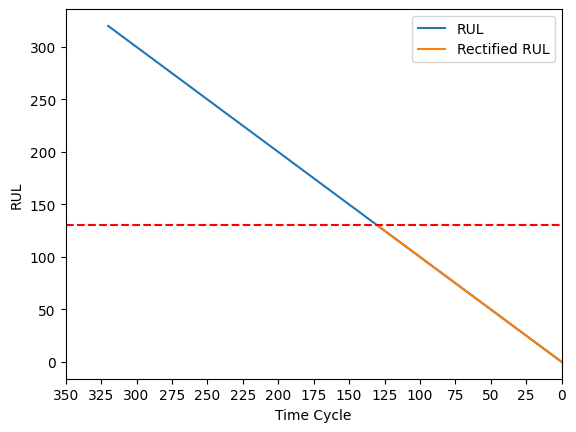

In [12]:
plt.plot('RUL', 'RUL',
                data=train[train['Unit']==1], label = 'RUL')
plt.plot('RUL', 'RUL', data=  train_clip[train_clip['Unit']==1], label = 'Rectified RUL')
plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
plt.xticks(np.arange(0, 375, 25))
# Add a horizontal dashed line at y=5
plt.axhline(y=130, linestyle='--', color='r')
plt.ylabel('RUL')
plt.xlabel('Time Cycle')
plt.legend()
plt.savefig('images/RUL_early.png')
plt.show()

In [17]:
alpha = 0.5
X_train_interim = add_operating_condition(train.drop(drop_sensors, axis=1))
X_test_interim = add_operating_condition(test.drop(drop_sensors, axis=1))

X_train_interim, X_test_interim = condition_scaler(X_train_interim, X_test_interim, remaining_sensors)

X_train_interim_smoothing = exponential_smoothing(X_train_interim, remaining_sensors, 0, alpha)
X_test_interim_smoothingg= exponential_smoothing(X_test_interim, remaining_sensors, 0, alpha)

In [66]:
def plot_signal_modif(df, signal_name,arg, unit=None):
    #     train = df
    plt.figure(figsize=(8,5))
    if unit:
        plt.plot('RUL', signal_name,
                data=df[df['Unit']==unit])
    else:
        for i in df['Unit'].unique()[:10]:
            if (i % 10 == 0):  # only ploting every 10th unit_nr
                plt.plot('RUL', signal_name,
                         data=df[df['Unit']==i])
    plt.xlim(350, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 375, 25))
    plt.ylabel(signal_name)
    plt.xlabel('Remaining Use fulLife')
    plt.title(arg)
    #plt.savefig(signal_name+'.jpeg')
    # plt.show()

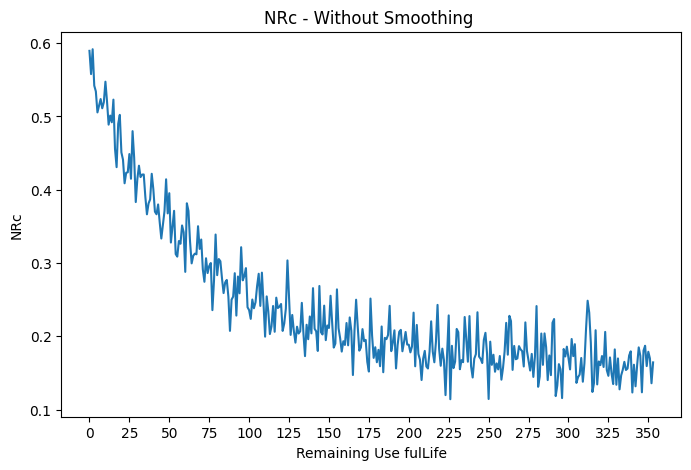

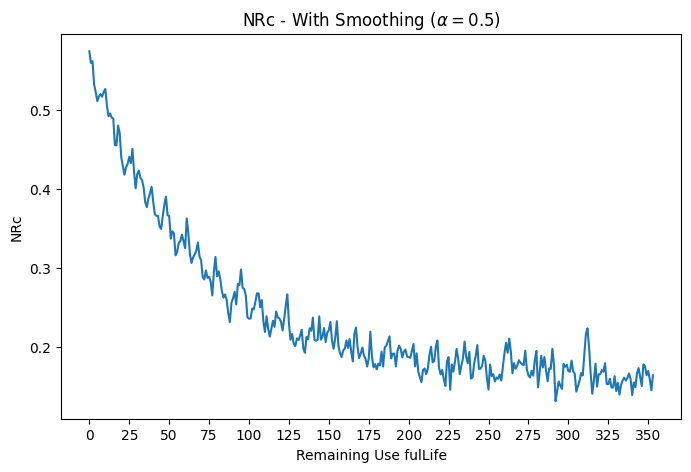

In [65]:
plot_signal_modif(X_train_interim, 'NRc', arg = 'NRc - Without Smoothing ')
plot_signal_modif(X_train_interim_smoothing, 'NRc', arg = r"NRc - With Smoothing ($\alpha=0.5$)")